# Image Classification using ResNet

## I. Prepocessing

#### 1. Zip File

In [ ]:
import zipfile
import os

zip_path = 'cnn_dataset.zip'
extract_path = 'cnn_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully.")

Dataset unzipped successfully.


#### 2. Importing Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn.functional as F
from scipy import stats
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
import time
import os
import h5py
from torchsummary import summary
from torchvision import transforms
from torch.utils import data
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split
from sklearn.preprocessing import normalize
from torchvision import transforms, datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import torch.nn as nn
import random

In [ ]:
dataset_path = 'cnn_dataset'
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

## II. Data Visualization

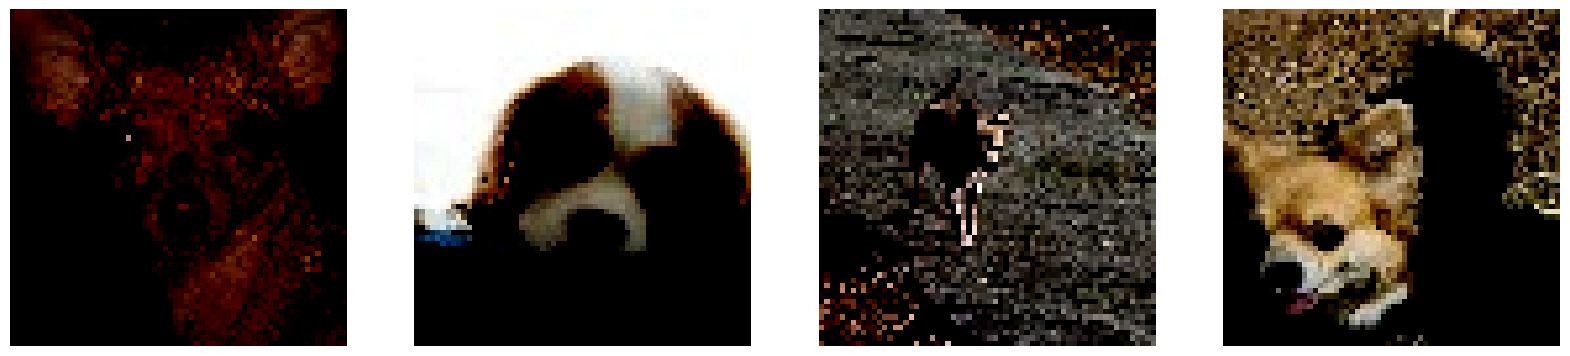

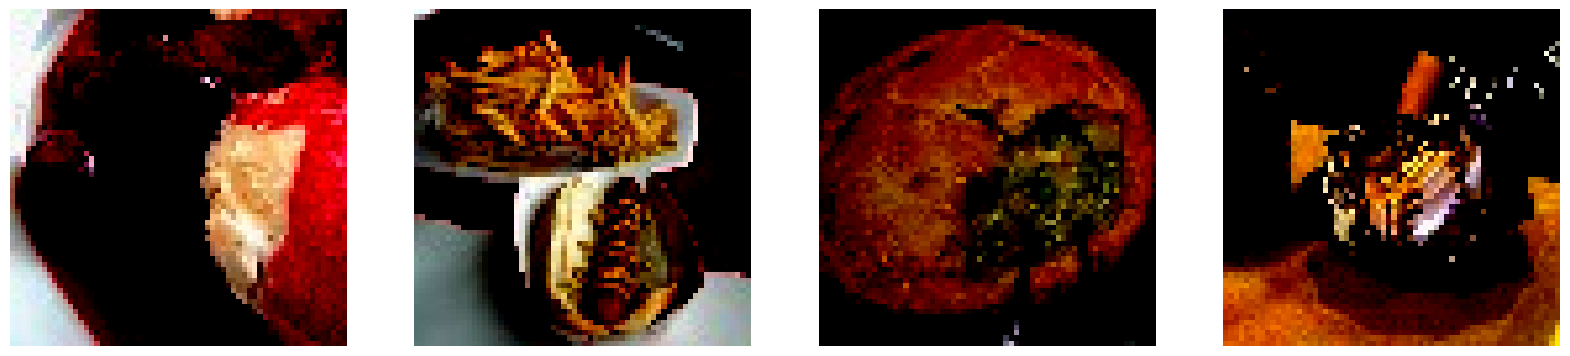

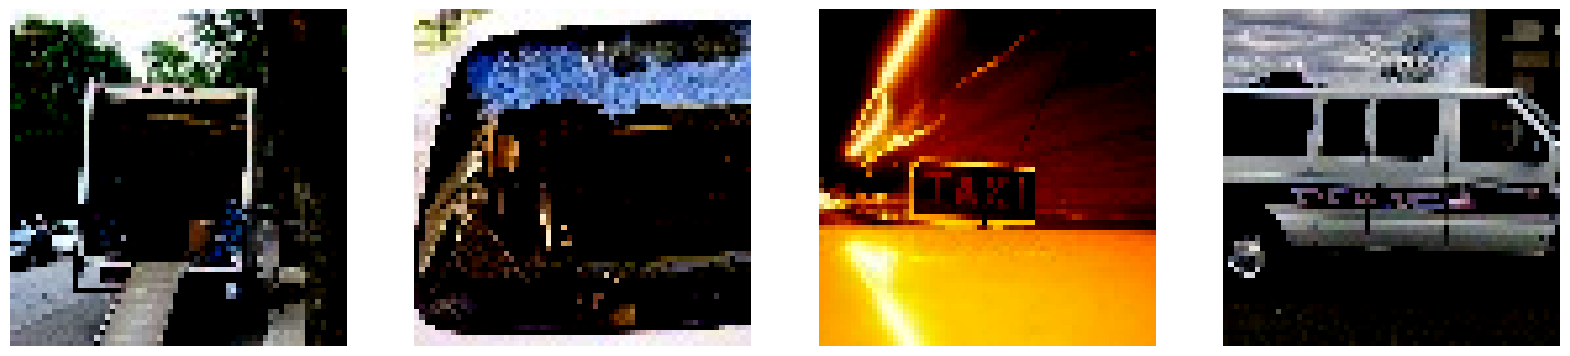

In [ ]:
def show_samples_per_class(dataset, num_classes, samples_per_class=4):
    class_indices = [[] for _ in range(num_classes)]


    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)


    for cls in range(num_classes):
        plt.figure(figsize=(5 * samples_per_class, 5))
        for i in range(samples_per_class):
            plt.subplot(1, samples_per_class, i + 1)
            idx = random.choice(class_indices[cls])
            image, label = dataset[idx]
            if image.shape[0] == 3:

                plt.imshow(image.permute(1, 2, 0))
            else:

                plt.imshow(image.squeeze(), cmap='gray')
            plt.axis('off')
        plt.show()

show_samples_per_class(dataset, num_classes=3)

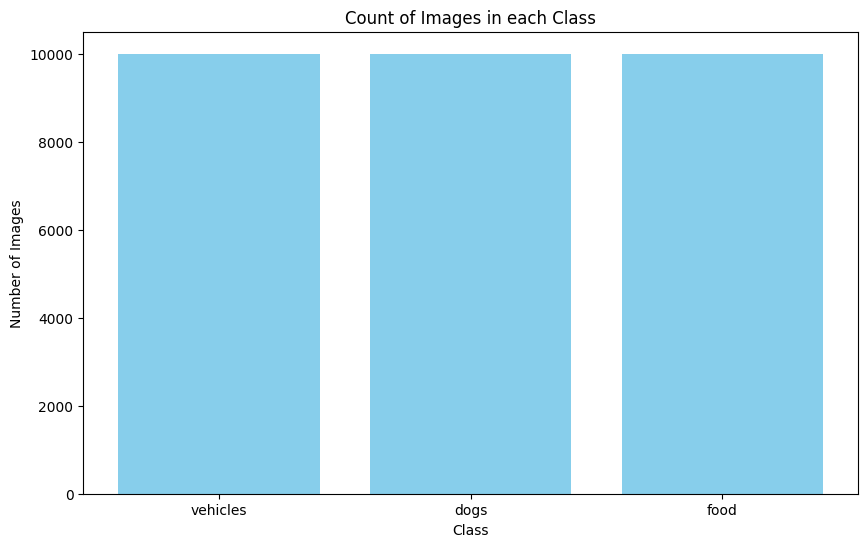

In [ ]:
lis = os.listdir(dataset_path)
dicti = {}
for i in lis:
    path_class = os.path.join(dataset_path, i)
    if os.path.isdir(path_class):
        num_images = len(os.listdir(path_class))
        dicti[i] = num_images

plt.figure(figsize=(10, 6))
plt.bar(dicti.keys(), dicti.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Count of Images in each Class')
plt.show()

## III. Data Splitting

In [ ]:
num_classes = len(dataset.classes)
num_train = int(0.7 * len(dataset))
num_val = int(0.15 * len(dataset))
num_test = len(dataset) - num_train - num_val

train_dataset, val_dataset, test_dataset = random_split(dataset, lengths=[num_train, num_val, num_test],
                                                        generator=torch.Generator().manual_seed(7))


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Number of classes in the dataset:", num_classes)
print("Length of dataset",len(dataset))
print("Length of train_size:", len(train_dataset))
print("Length of val_size:", len(val_dataset))
print("Length of test_size:", len(test_dataset))

Number of classes in the dataset: 3
Length of dataset 30000
Length of train_size: 21000
Length of val_size: 4500
Length of test_size: 4500


## IV. Resnet Model

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

model = ResNet(BasicBlock, [2, 2, 2, 2])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(model)
model = model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model,input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

## V. Training and Evaluation

#### 1. Normal

In [ ]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        total = 0
        correct = 0
        for inputs, labels in train_loader:
            inputs, labels = next(iter(train_loader))
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total +=  labels.size(0)
            correct +=  (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100*correct / total)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total +=  labels.size(0)
                correct +=  (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100*correct / total)
        print('Epoch:', epoch+1, ' Train Accuracy: {:.2f}%'.format(train_accuracies[-1]),
              ' Train Loss:', train_losses[-1],' Validation Accuracy: {:.2f}%'.format(val_accuracies[-1]), ' Validation Loss:', val_losses[-1])

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


Epoch: 1  Train Accuracy: 85.47%  Train Loss: 0.37903145426674817  Validation Accuracy: 82.18%  Validation Loss: 0.492302643791051
Epoch: 2  Train Accuracy: 92.64%  Train Loss: 0.2116980686512037  Validation Accuracy: 83.78%  Validation Loss: 0.46891806012308096
Epoch: 3  Train Accuracy: 94.80%  Train Loss: 0.14952749088066872  Validation Accuracy: 85.29%  Validation Loss: 0.449985130676921
Epoch: 4  Train Accuracy: 96.01%  Train Loss: 0.11373605392873287  Validation Accuracy: 87.13%  Validation Loss: 0.4215042329799961
Epoch: 5  Train Accuracy: 97.14%  Train Loss: 0.0796173999006761  Validation Accuracy: 87.80%  Validation Loss: 0.44320372313680784


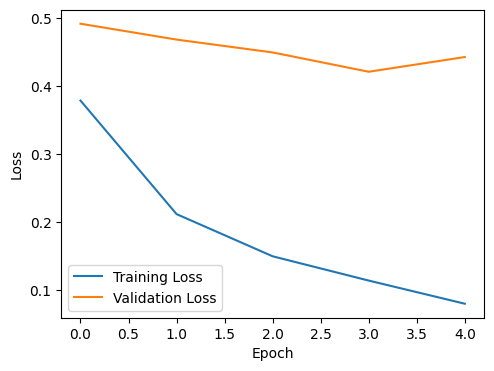

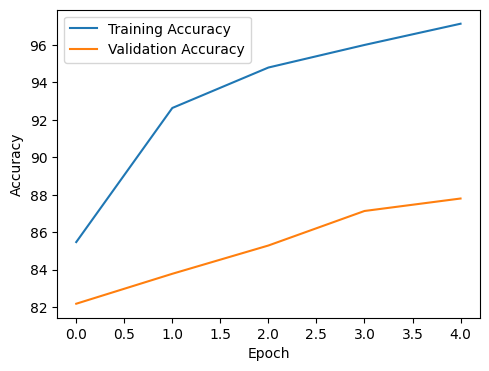

In [ ]:
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5)

In [ ]:
def test_accuracy(model, test_loader):
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Test Accuracy:', correct*100 // total,"%")
    print('Test Loss:', test_loss/len(test_loader))

test_accuracy(model, test_loader)

Test Accuracy: 88 %
Test Loss: 0.42730575380191


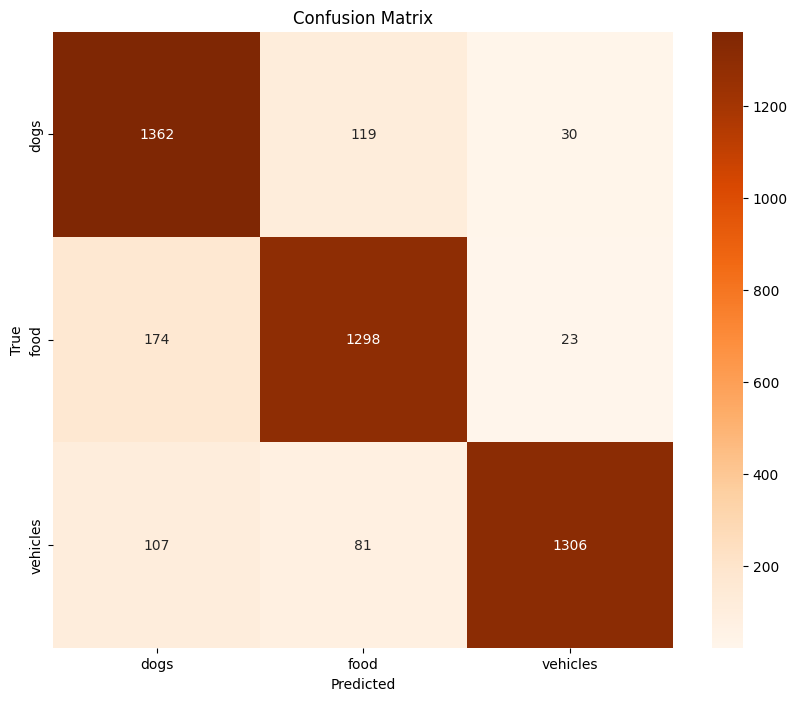

In [ ]:
#Confusion Matrix
y_true = []
y_pred = []
def confusion_plot(model, test_loader):
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

confusion_plot(model, test_loader)

In [ ]:
#Evaluation Metrics
def metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))

metrics(y_true, y_pred)

Precision: 0.89
Recall: 0.88
F1 Score: 0.88


In [ ]:
torch.save(model.state_dict(), 'Resnet.h5')

#### 2. L2 Regularization

Epoch: 1  Train Accuracy: 97.43%  Train Loss: 0.07534724259097979  Validation Accuracy: 88.87%  Validation Loss: 0.42483380069615134
Epoch: 2  Train Accuracy: 97.71%  Train Loss: 0.06676121812744072  Validation Accuracy: 88.47%  Validation Loss: 0.41317083613133765
Epoch: 3  Train Accuracy: 98.33%  Train Loss: 0.04748971059587204  Validation Accuracy: 88.40%  Validation Loss: 0.39990828144298474
Epoch: 4  Train Accuracy: 98.35%  Train Loss: 0.046025200480861325  Validation Accuracy: 86.91%  Validation Loss: 0.4927913657796215
Epoch: 5  Train Accuracy: 98.58%  Train Loss: 0.0411191923950026  Validation Accuracy: 88.16%  Validation Loss: 0.44149131957494037


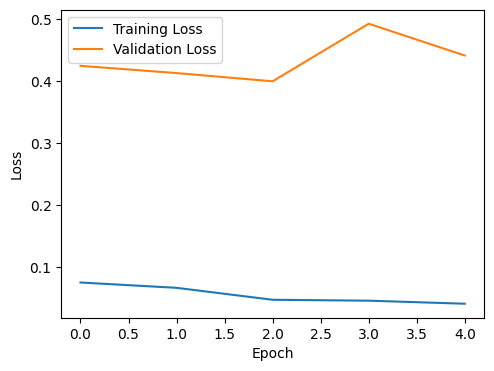

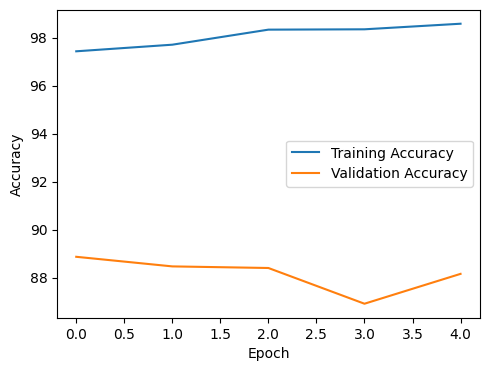

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5)


In [ ]:
def test_accuracy(model, test_loader):
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            #labels = labels.squeeze(1)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Test Accuracy:', correct*100 // total,"%")
    print('Test Loss:', test_loss/len(test_loader))

In [ ]:
test_accuracy(model, test_loader)

Test Accuracy: 88 %
Test Loss: 0.4299650329729201


In [ ]:
def confusion_plot(model, test_loader):
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

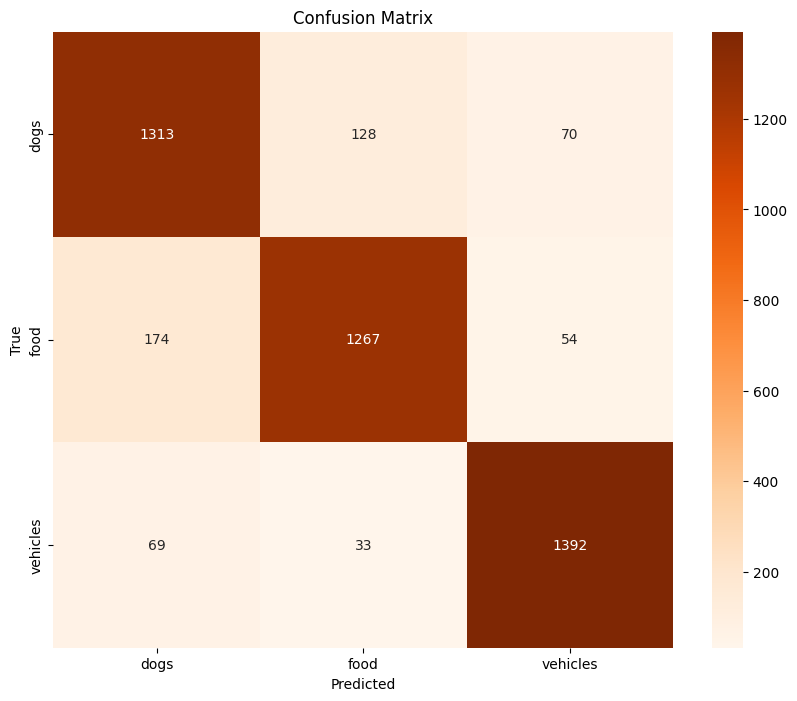

In [ ]:
#Confusion Matrix
y_true = []
y_pred = []
confusion_plot(model, test_loader)

In [ ]:
#Evaluation Metrics
def metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))

In [ ]:
#Evaluation Metrics
metrics(y_true, y_pred)

Precision: 0.88
Recall: 0.88
F1 Score: 0.88


#### 3.Early Stopping

In [ ]:
#Training and Validation
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5, patience=5):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    early_stopping_counter = 0
    best_val_loss = np.inf

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        total = 0
        correct = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)
        print('Epoch:', epoch+1, ' Train Accuracy: {:.2f}%'.format(train_accuracies[-1]),
              ' Train Loss:', train_losses[-1], ' Validation Accuracy: {:.2f}%'.format(val_accuracies[-1]), ' Validation Loss:', val_losses[-1])

        # Early stopping
        if val_loss / len(val_loader) < best_val_loss:
            best_val_loss = val_loss / len(val_loader)
            early_stopping_counter = 0  # Reset counter
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping triggered. Stopping training after {epoch+1} epochs.")
                break  # Stop training

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


Epoch: 1  Train Accuracy: 98.36%  Train Loss: 0.044932619530189566  Validation Accuracy: 88.16%  Validation Loss: 0.48184647306170264
Epoch: 2  Train Accuracy: 98.85%  Train Loss: 0.030640130809162912  Validation Accuracy: 88.56%  Validation Loss: 0.4727797594288705
Epoch: 3  Train Accuracy: 98.94%  Train Loss: 0.030636788311196452  Validation Accuracy: 89.27%  Validation Loss: 0.4933150363430171
Epoch: 4  Train Accuracy: 98.97%  Train Loss: 0.030702837185734615  Validation Accuracy: 89.04%  Validation Loss: 0.4595338240475722
Epoch: 5  Train Accuracy: 98.71%  Train Loss: 0.03687725273429099  Validation Accuracy: 89.00%  Validation Loss: 0.444019229059488


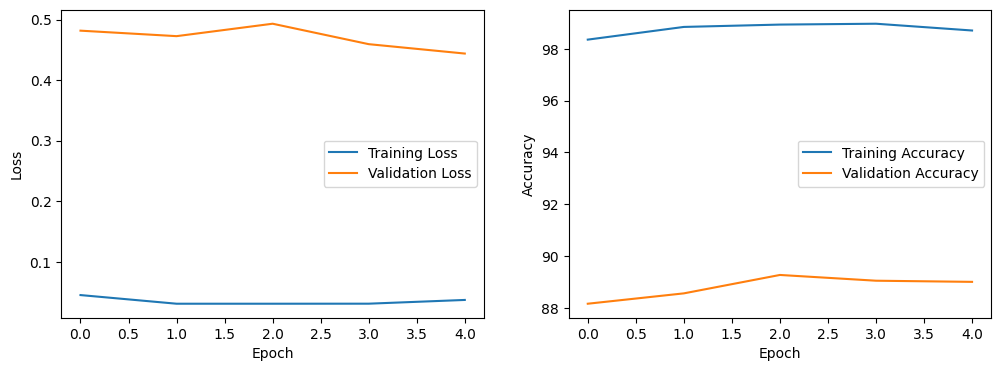

Test Accuracy: 89 %
Test Loss: 0.43240036091334383


In [ ]:
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5)
test_accuracy(model, test_loader)

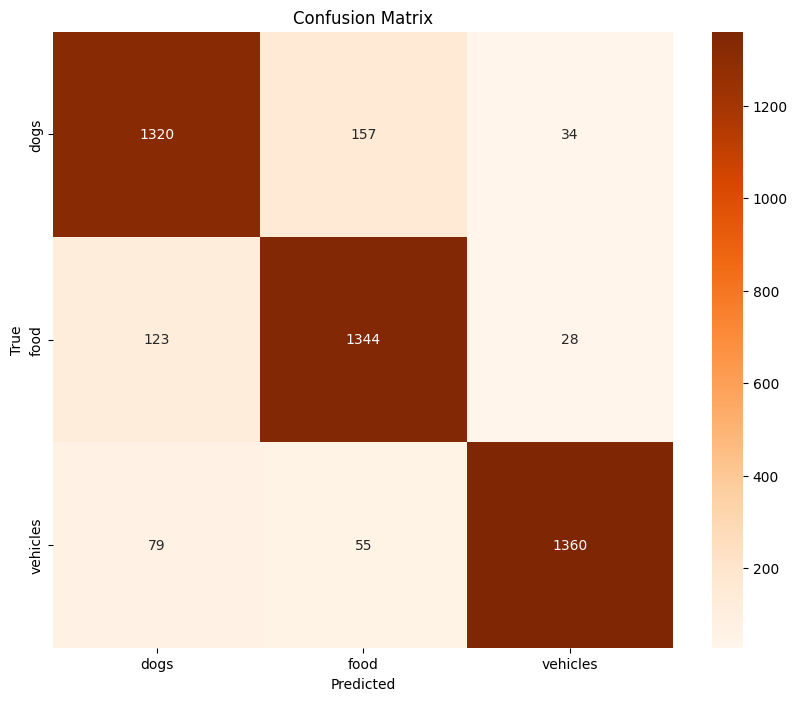

In [ ]:
#Confusion Matrix
y_true = []
y_pred = []
confusion_plot(model, test_loader)

In [ ]:
#Evaluation Metrics
metrics(y_true, y_pred)

Precision: 0.90
Recall: 0.89
F1 Score: 0.89
